# Calibration of Local Stochastic Volatility Models to Market Smiles 

## I. Some Black Scholes Routines

In [1]:
# Utility functions for lognormal distributions and Black Scholes model

%matplotlib inline
import numpy as np
from scipy.stats import norm

def lognormal_price(stdev, fwd, strike, IsCall):
    """Lognormal price.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns        E[(L - K)_+]    if        IsCall == true
    returns        E[(K - L)_+]    if        IsCall == false
    
    - fwd and stdev must be non-negative
    - the  returned value is non-negative
    """
    intrinsic_value = max(fwd - strike, 0.0) if IsCall else max(strike - fwd, 0.0)
    time_value = lognormal_time_value(stdev, fwd, strike)
    return intrinsic_value + time_value

lognormal_price = np.vectorize(lognormal_price)

def lognormal_time_value(stdev, fwd, strike):
    """Lognormal time value.

    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)
    
    returns                       E[(L - K)_+] - (E[L] - K)_+
    which is also equal to        E[(K - L)_+] - (K - E[L])_+

    - fwd and stdev must be non-negative
    - returned value is non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d2 = -np.log(strike / fwd) / stdev - 0.5 * stdev
        d1 = d2 + stdev
        if strike >= fwd:
            return fwd * norm.cdf(d1) - strike * norm.cdf(d2)
        else:
            return strike * norm.cdf(-d2) - fwd * norm.cdf(-d1)

lognormal_time_value = np.vectorize(lognormal_time_value)

def lognormal_gamma(stdev, fwd, strike):                        
    """Lognormal Gamma.
    
    Consider    G ~ N(0, stdev^2)  and   L := fwd * exp(G - stdev^2 / 2)

    returns        d2 Call / d fwd2   if        IsCall == True
    returns        d2 Put / d fwd2    if        IsCall == False
    
    - fwd and stdev must be non-negative
    """
    if strike <= 0.0 or stdev <= 0.0:
        return 0.0
    else:
        d1 = -np.log(strike / fwd) / stdev + 0.5 * stdev
        return norm.pdf(d1) / (stdev * fwd)

lognormal_gamma = np.vectorize(lognormal_gamma)

def black_scholes_time_value(volatility, fwd, maturity, strike):
    """Time-value of a Call or Put option in the Black-Scholes model.
    
    dS_t = S_t volatility dW_t
    S_0 = fwd
       
    time_value = E[(S_T - strike)+] - (E[S_T] - strike)_+

    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_time_value(volatility * np.sqrt(maturity), fwd, strike)

def black_scholes_price(volatility, fwd, maturity, strike, IsCall):
    """Price of a Call or Put option in the Black-Scholes model.

    dS_t = S_t volatility dW_t
    S_0 = fwd

    returns        E[(S_T - strike)_+]    if   IsCall == true
`   returns        E[(strike - S_T)_+]    if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity must be non-negative')
    return lognormal_price(volatility * np.sqrt(maturity), fwd, strike, IsCall)

def black_scholes_gamma(volatility, fwd, maturity, strike):
    """Gamma of a Call or Put option in the Black-Scholes model.

       dS_t = S_t volatility dW_t
       S_0 = fwd

    returns        d2 E[(S_T - strike)_+] / dfwd2   if   IsCall == true
    returns        d2 E[(strike - S_T)_+] / dfwd2   if   IsCall == false
   
    - volatility, fwd and maturity must be non-negative.
    - the returned values is non-negative.
    """
    if maturity < 0.0:
        raise ValueError('maturity has to be non-negative')
    return lognormal_gamma(volatility * np.sqrt(maturity), fwd, strike)

In [2]:
import matplotlib.pyplot as plt

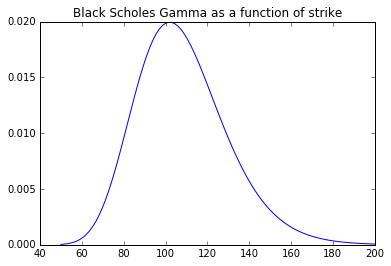

In [3]:
# Simple plot of the Black Scholes Gamma

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_gamma(0.2, 100.0, 1.0, strikes))
plt.title('Black Scholes Gamma as a function of strike')
plt.show()

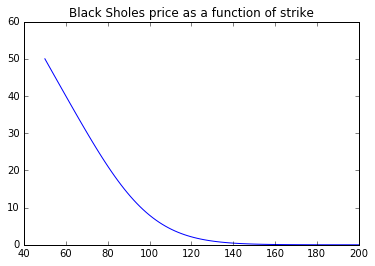

In [4]:
# Simple plot of the Black Scholes price

strikes = np.linspace(50, 200, 100)
plt.plot(strikes, black_scholes_price(0.2, 100.0, 1.0, strikes, True))
plt.title('Black Sholes price as a function of strike')
plt.show()

In [5]:
# Naive implementation of volatility inversion.

from scipy.optimize import brentq

def time_value_vol_inversion(strike, maturity, fwd, time_value):
    """Implied volatility computation for a given time value.
    
    Value of volatility such that:
    
    ``black_scholes_time_value(volatility, maturity, fwd, strike) == time_value``.
    
    - maturity and time_value must be non-negative
    - the returned value is non-negative
    """ 
    if time_value == 0.0:
        return 0.0
    def func(volat):
        return black_scholes_time_value(volat, fwd, maturity, strike) - time_value
    return brentq(func, 0.01, 3.00)

def vol_inversion(strike, maturity, fwd, option_price, IsCall):
    """Implied volatility computation for a given option price.
    
    Value of volatility such that:
    
    ``black_scholes_price(volatility, maturity, fwd, strike, IsCall) == option_price``.
    
    - maturity must be non-negative
    - time value must be non-negative
    - the returned value is non-negative
    """
    if IsCall:
        time_value = option_price - max(fwd - strike, 0.0)
    else:
        time_value = option_price - max(strike - fwd, 0.0) 
    return time_value_vol_inversion(strike, maturity, fwd, time_value)

In [6]:
# Simple volatility inversion test.
maturity = 1.0
strike = 100.0
fwd = 100.0
option_price = black_scholes_price(0.3, fwd, maturity, strike, True)
vol_inversion(strike, maturity, fwd, option_price, True)

0.3

## II. The Black-Scholes Robustness Formula

- Describe and implement a Monte Carlo procedure exploiting formula 

$$
C(K, T) = C_{\textrm{BS}}(0, S_0, K, \sigma_{\textrm{BS}}, T) + \frac{1}{2} \mathbb{E} \left[ \int_0^T \left( \sigma_t^2 - \sigma_{\textrm{BS}}^2 \right) S_t^2 \partial_{xx}^2 C_{\textrm{BS}} (t, S_t; \sigma_{\textrm{BS}}, K, T )dt \right]. \qquad 
$$

to compute the implied volatility of vanilla options in the following model (stochastic lognormal volatility):

$$
\begin{array}{l}
dS_t = a_t S_t dW^{(1)}_t,\\
d a_t = a_t \gamma dW^{(2)}_t,\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

We first generate Monte Carlo path for the stochastic lognormal volatility as following

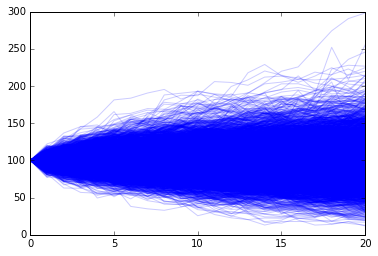

In [7]:
## Function for simulating stochastic lognormal volatility model

def lognormal_volatility_path(nb_mc, nb_step, S0, a0, gamma, rho, T): 
    
    S = np.empty((nb_step + 1, nb_mc))
    a = np.empty((nb_step + 1, nb_mc))
    for i in range(nb_step + 1):
        if i == 0:
            S[i] = S0
            a[i] = a0
        else:
            dw1 = np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            dw2 = rho * dw1 + np.sqrt(1 - rho ** 2) * np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            S[i] = S[i - 1] + a[i - 1] * S[i - 1] * dw1
            a[i] = a[i - 1] + a[i - 1] * gamma * dw2
            
            # Exclude outliers
            for j in range(nb_mc):
                if S[i][j] <= 0 or S[i][j] >= S0 * 3:
                    S[i][j] = S[i - 1][j]
    
    return (S, a)

# Numerical values for the model parameters 
T = 1.0
gamma = 0.5
a0 = 0.3
S0 = 100.0
rho = -0.5

# Payoff: ATM Call
K = 100

def payoff(S, K):
    return np.maximum(S - K, 0)

# Generate MC path
nb_mc = 4000
nb_step = 20
(S_path, a_path) = lognormal_volatility_path(nb_mc, nb_step, S0, a0, gamma, rho, T)

# Plot the MC path
plt.figure()
plt.plot(S_path, 'b', alpha=0.2)
plt.show()

The expectation term can be estimated by the generated Monte Carlo path, then $C(K, T)$ can be computed as following

In [8]:
# Function for pricing using Black-Scholes Robustness Formula

def price_BS_Robustness(S, sigma, S0, K, T, sigma_BS):
    
    nb_step = S.shape[0] - 1
    dt = T / nb_step
    estimation = 0
    for i in range(1, nb_step + 1):
        estimation += np.mean(0.5 * (sigma[i] ** 2 - sigma_BS ** 2) * S[i] ** 2 \
                                  * black_scholes_gamma(sigma_BS, S[i], T - i * dt, K) * dt)

    return estimation + black_scholes_price(sigma_BS, S0, T, K, True)

# Function for finding implied volatility using Black-Scholes Robustness Formula
def ImVol_BS_Robustness(S, sigma, S0, K, T, sigma_BS):
    return vol_inversion(K, T, S0, price_BS_Robustness(S, sigma, S0, K, T, sigma_BS), True)

# Compute implied volatility using Black-Scholes Robustness Formula
print "Price using Black-Scholes Robustness Formula:", price_BS_Robustness(S_path, a_path, S0, K, T, a0)
print "Implied volatility using a naive Monte Carlo procedure:", ImVol_BS_Robustness(S_path, a_path, S0, K, T, a0)

Price using Black-Scholes Robustness Formula: 11.902263566
Implied volatility using a naive Monte Carlo procedure: 0.299460694734


In [9]:
# Investigate how the choice of sigma_BS affect on the result of BS Robustness Formula

print "nb_mc = 4000, nb_step = 20"
for i in range(5):
    print "Price ( sigma_BS =", 0.1*(i+1), "):", price_BS_Robustness(S_path, a_path, S0, K, T, 0.1 * (i+1))  

print "nb_mc = 4000, nb_step = 40"
(S_path_large, a_path_large) = lognormal_volatility_path(nb_mc, 2 * nb_step, S0, a0, gamma, rho, T)
for i in range(5):
    print "Price ( sigma_BS =", 0.1*(i+1), "):", price_BS_Robustness(S_path_large, a_path_large, S0, K, T, 0.1 * (i+1)) 

nb_mc = 4000, nb_step = 20
Price ( sigma_BS = 0.1 ): 11.3718739483
Price ( sigma_BS = 0.2 ): 11.6890598718
Price ( sigma_BS = 0.3 ): 11.902263566
Price ( sigma_BS = 0.4 ): 12.1160640877
Price ( sigma_BS = 0.5 ): 12.346888341
nb_mc = 4000, nb_step = 40
Price ( sigma_BS = 0.1 ): 11.5240282321
Price ( sigma_BS = 0.2 ): 11.6935659281
Price ( sigma_BS = 0.3 ): 11.8160520825
Price ( sigma_BS = 0.4 ): 11.9326896056
Price ( sigma_BS = 0.5 ): 12.0526639696


From above we can see that as we increases the meshs of time discretization, the numerical results from using BS Robustness Formula become less sensitive to $\sigma_{\textrm{BS}}$. And we can expect that the numerical results become insensitive to $\sigma_{\textrm{BS}}$ if the mesh is fine enough, which is consistent with the theoretical meaning of the formula that the result $C(K, T)$ is invariant to $\sigma_{\textrm{BS}}$.

- Compare and validate your result with the one of a naive Monte Carlo procedure. Compare the variance of the two estimators of implied volatilities. 

In [10]:
# Function for pricing using a naive Monte Carlo procedure
def price_naive_MC(S_path):
    return np.mean(payoff(S_path[-1], K))

# Function for finding implied volatility using a naive Monte Carlo procedure
def ImVol_naive_MC(S_path, S0, K, T):
    return vol_inversion(K, T, S0, price_naive_MC(S_path), True)

# Compare the prices of two methods
print "Price using Black-Scholes Robustness Formula:", price_BS_Robustness(S_path, a_path, S0, K, T, a0)
print "Price using a naive Monte Carlo procedure:", price_naive_MC(S_path)

# Compare the implied volatilities of two methods
print "Implied volatility using Black-Scholes Robustness Formula:", ImVol_BS_Robustness(S_path, a_path, S0, K, T, a0)
print "Implied volatility using a naive Monte Carlo procedure:", ImVol_naive_MC(S_path, S0, K, T)

Price using Black-Scholes Robustness Formula: 11.902263566
Price using a naive Monte Carlo procedure: 12.2751236473
Implied volatility using Black-Scholes Robustness Formula: 0.299460694734
Implied volatility using a naive Monte Carlo procedure: 0.308915648332


In [11]:
# Compare the variance of the two estimators of implied volatilities.

nb_mc = 100
ImVol_BS = np.empty(nb_mc)
ImVol_naive = np.empty(nb_mc)

for i in range(nb_mc):
    (S_path, a_path) = lognormal_volatility_path(100, 10, S0, a0, gamma, rho, T)
    ImVol_BS[i] = ImVol_BS_Robustness(S_path, a_path, S0, K, T, a0)
    ImVol_naive[i] = ImVol_naive_MC(S_path, S0, K, T)
    
print "Variance of ImVol using Black-Scholes Robustness Formula:", np.var(ImVol_BS)
print "Variance of ImVol using a naive Monte Carlo procedure:", np.var(ImVol_naive)

Variance of ImVol using Black-Scholes Robustness Formula: 6.74602235333e-05
Variance of ImVol using a naive Monte Carlo procedure: 0.00167424772601


From the numerical results above, we can conclude that the variance of implied volatility using Black-Scholes Robustness Formula is much smaller than the variance of implied volatility using a naive Monte Carlo procedure. 

## III.  The particle method and the smile calibration problem

Let us consider a modified version of the previous model, where we add local volatility term (or leverage function) $l$ in the stock dynamics:

$$
\begin{array}{l}
dS_t = a_t l(t, S_t) S_t dW^{(1)}_t\\
d a_t = a_t \gamma dW^{(2)}_t\\
d \langle W^{(1)}, W^{(2)} \rangle_t = \rho dt.
\end{array}
$$

The numerical values for the model parameters are
- $T = 1$.
- $\gamma = 50\%$.
- $a_0 = 30\%$.
- $S_0 = 100$.
- $\rho = -50\%$.

The goal is to find a leverage function $l(t, x)$ so that this model matches the market prices of vanilla options. For the sake of simplicity, we assume that all the vanilla option prices in the market are such that they match those of a Black-Scholes model, ie. the market implied volatility surface is flat $\sigma_{\textrm{Market}} \equiv 30\%$. In that case, we also have $\sigma_{\textrm{Dup}}(t,x) \equiv 30\%$.

### Implementation
- Implement the particle method studied in class to set the leverage function $l$. For this purpose, you may use the non-parametric regression routines provided in the previous assignments.

In [12]:
# Non-parametric regression function

def reg_non_param(x, bdwidth, x_sample, y_sample):
    """Values of the non-parametric regression of Y wrt X using a Gaussian kernel.

    Parameters
    ----------
    x: numpy array, one dimensional
        Values at which the regression is evaluated
    bdwidth: positive float, value of the bandwidth parameter
    x_sample: numpy array, one dimensional, non-empty
        x values of the sample
    y_sample: numpy array, one dimensional
        y values of the sample, must have the same length as x_sample.    
    """
    def kern(u, x):
        """Gaussian kernel function"""
        return np.exp(-(u[:, np.newaxis] - x) ** 2 / (2 * bdwidth ** 2))

    return np.sum(kern(x_sample, x) * y_sample[:, np.newaxis], axis=0) \
        / np.sum(kern(x_sample, x), axis=0)

In [13]:
# Numerical values for the model parameters 
T = 1.0
gamma = 0.5
a0 = 0.3
S0 = 100.0
rho = -0.5

# Market implied volatilities 
sigma_Dup = 0.3

# Set mesh for the leverage function
std = int(np.std(S_path[-1]))
mesh = np.linspace(K - std, K + std, 20)

# Sample size and time discretization
nb_mc = 4000
nb_step = 20

# Function for using particle method to set the leverage function

def particle_method(nb_mc, nb_step, mesh, S0, a0, gamma, rho, T, sigma_Dup):
    
    S = np.empty((nb_step + 1, nb_mc))
    a = np.empty((nb_step + 1, nb_mc))
    l_path = np.empty((nb_step + 1, nb_mc))
    l_mesh = np.empty((nb_step + 1, len(mesh)))
    
    for i in range(nb_step + 1):
        if i == 0:
            S[i] = S0
            a[i] = a0
            l_path[i] = sigma_Dup / a0
            l_mesh[i] = sigma_Dup / a0
        else:
            dw1 = np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            dw2 = rho * dw1 + np.sqrt(1 - rho ** 2) * np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            S[i] = S[i - 1] + a[i - 1] * l_path[i - 1] * S[i - 1] * dw1
            a[i] = a[i - 1] + a[i - 1] * gamma * dw2
            l_path[i] = sigma_Dup / np.sqrt(reg_non_param(S[i], 0.2 * np.std(S[i]), S[i], a[i] ** 2))
            l_mesh[i] = sigma_Dup / np.sqrt(reg_non_param(mesh, 0.2 * np.std(S[i]), S[i], a[i] ** 2))
            
    return l_mesh

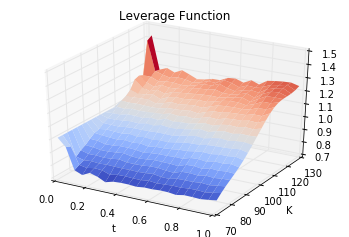

In [14]:
# Compute and plot leverage function using particle method

leverage = particle_method(nb_mc, nb_step, mesh, S0, a0, gamma, rho, T, sigma_Dup)

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.empty(leverage.shape)
y = np.empty(leverage.shape)

for i in range(nb_step + 1):
    for j in range(len(mesh)):
        x[i][j] = i * 1.0 / nb_step
        y[i][j] = mesh[j]

ax.plot_surface(x, y, leverage, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
ax.set_xlabel('t')
ax.set_ylabel('K')
ax.set_title('Leverage Function')

- Using the Monte Carlo method devised in the previous section, check that the resulting model is indeed calibrated to the market implied volatilities $\sigma_{\textrm{Market}} \equiv 30\%$.

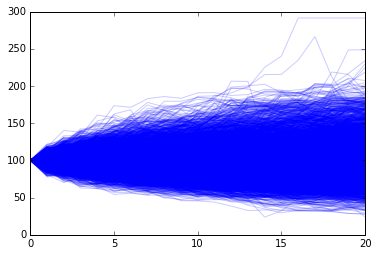

In [15]:
# Function for simulating stochastic local volatility model

def local_volatility_path(nb_mc, nb_step, S0, a0, gamma, rho, T, mesh, leverage): 
    
    S = np.empty((nb_step + 1, nb_mc))
    a = np.empty((nb_step + 1, nb_mc))
    l = np.empty((nb_step + 1, nb_mc))
    sigma = np.empty((nb_step + 1, nb_mc))
    
    for i in range(nb_step + 1):
        if i == 0:
            S[i] = S0
            a[i] = a0
            l[i] = leverage[0][0]
            sigma[i] = a[i] * l[i]
        else:
            dw1 = np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            dw2 = rho * dw1 + np.sqrt(1 - rho ** 2) * np.random.randn(nb_mc) * np.sqrt(T / nb_step)
            S[i] = S[i - 1] + sigma[i - 1] * S[i - 1] * dw1
            a[i] = a[i - 1] + a[i - 1] * gamma * dw2
            
            # Exclude outliers
            for j in range(nb_mc):
                if S[i][j] <= 0 or S[i][j] >= S0 * 3:
                    S[i][j] = S[i - 1][j]
            
            # Interpolation using Cubic Spline on the leverage function surface
            from scipy.interpolate import UnivariateSpline
            f = UnivariateSpline(mesh, leverage[i], k = 3)
            l[i] = f(S[i])
            
            sigma[i] = a[i] * l[i]
            
    return (S, sigma)

# Generate and plot MC path
(S_path, sigma_path) = local_volatility_path(nb_mc, nb_step, S0, a0, gamma, rho, T, mesh, leverage)
plt.figure()
plt.plot(S_path, 'b', alpha=0.2)
plt.show()

In [16]:
# Check that the resulting model is indeed calibrated to the market implied volatilities 30%

print "Price using BS Robustness Formula:", price_BS_Robustness(S_path, sigma_path, S0, K, T, a0)
print "Price using a naive Monte Carlo procedure:", price_naive_MC(S_path)

print "Implied volatility using BS Robustness Formula:", ImVol_BS_Robustness(S_path, sigma_path, S0, K, T, a0)
print "Implied volatility using a naive Monte Carlo procedure:", ImVol_naive_MC(S_path, S0, K, T)

Price using BS Robustness Formula: 11.8442775111
Price using a naive Monte Carlo procedure: 11.6319036297
Implied volatility using BS Robustness Formula: 0.297990895882
Implied volatility using a naive Monte Carlo procedure: 0.292609126415


### Interpretation
- While setting $\rho = 0\%$, plot the calibrated leverage function $l(t, S)$ as a function of the spot value for a fixed maturity e.g. $t = T$. Plot the corresponding smile for the pure stochastic volatility model ($l \equiv 1$). By changing the value of the volatility of volatility, comment on the dependence of the shape of the leverage function on the volatility of volatility $\gamma$. Values for $\gamma$: $0\%$, $25\%$, $50\%$, $75\%$.

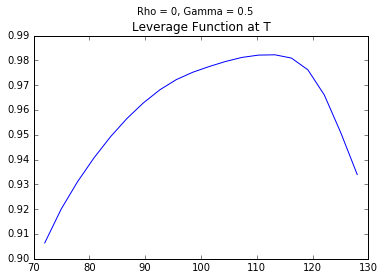

In [17]:
# Function for plotting the calibrated leverage function as a function of the spot value for fixed maturity T

def plot_leverage(nb_mc, nb_step, mesh, S0, a0, gamma, rho, T, sigma_Dup):
    
    leverage = particle_method(nb_mc, nb_step, mesh, S0, a0, gamma, rho, T, sigma_Dup)
    plt.figure()
    plt.plot(mesh, leverage[-1], 'b')
    plt.title('Leverage Function at T')
    plt.suptitle('Rho = %s, Gamma = %s'%(rho, gamma), y = 1)
    plt.show() 
    plt.show()
    
# Plot the calibrated leverage function when rho = 0
plot_leverage(8000, 5, mesh, S0, a0, gamma, 0, T, sigma_Dup)

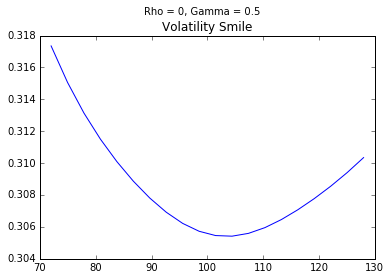

In [18]:
# Function for plotting the volatility smile for the pure stochastic volatility model

def plot_smile(nb_mc, nb_step, mesh, S0, a0, gamma, rho, T):
    
    (S_path, a_path) = lognormal_volatility_path(nb_mc, nb_step, S0, a0, gamma, rho, T)
    ImVol = np.empty(len(mesh))
    for i in range(len(mesh)): 
        ImVol[i] = ImVol_BS_Robustness(S_path, a_path, S0, mesh[i], T, a0)
        
    plt.figure()
    plt.plot(mesh, ImVol, 'b')
    plt.title('Volatility Smile')
    plt.suptitle('Rho = %s, Gamma = %s'%(rho, gamma), y = 1)
    plt.show() 

# Generate path for pure stochastic volatility model
plot_smile(1000, 10, mesh, S0, a0, gamma, 0, T)

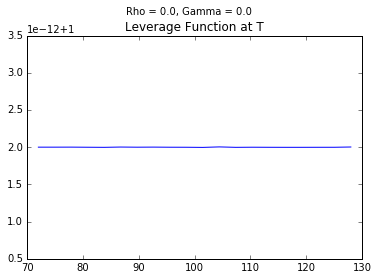

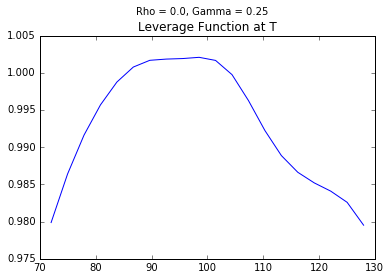

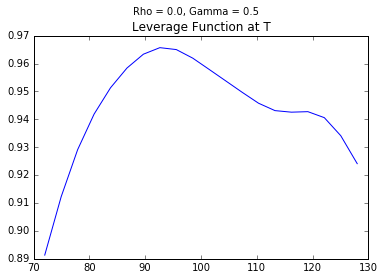

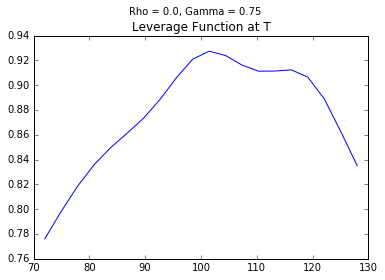

In [19]:
# Investigate the dependence of the shape of the leverage function on the volatility of volatility

plot_leverage(8000, 5, mesh, S0, a0, 0.0, 0.0, T, sigma_Dup)
plot_leverage(8000, 5, mesh, S0, a0, 0.25, 0.0, T, sigma_Dup)
plot_leverage(8000, 5, mesh, S0, a0, 0.5, 0.0, T, sigma_Dup)
plot_leverage(8000, 5, mesh, S0, a0, 0.75, 0.0, T, sigma_Dup)

From plots above, we can see that the volatility of calibrated leverage function increases as $\gamma$ (volatility of volatility) increases.

- For $\gamma = 50\%$, study the joint dependence of the slope of the leverage function and of the smile of the pure stochastic volatility model on the correlation parameter $\rho$.

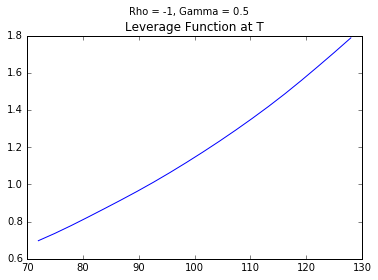

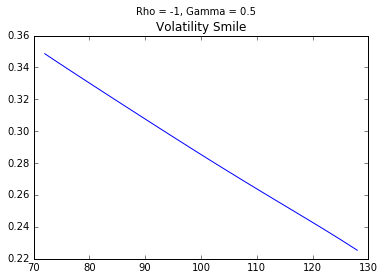

In [20]:
# Rho = -1
plot_leverage(8000, 5, mesh, S0, a0, gamma, -1, T, sigma_Dup)
plot_smile(1000, 10, mesh, S0, a0, gamma, -1, T)

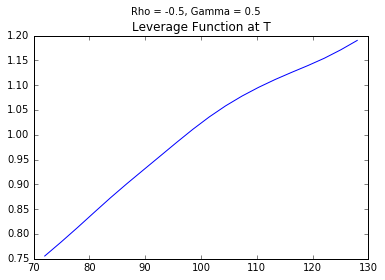

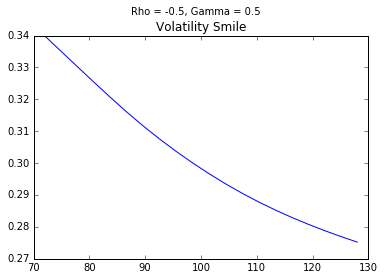

In [21]:
# Rho = -0.5
plot_leverage(8000, 5, mesh, S0, a0, gamma, -0.5, T, sigma_Dup)
plot_smile(1000, 10, mesh, S0, a0, gamma, -0.5, T)

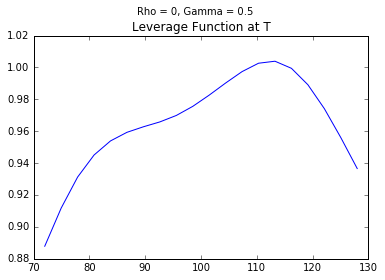

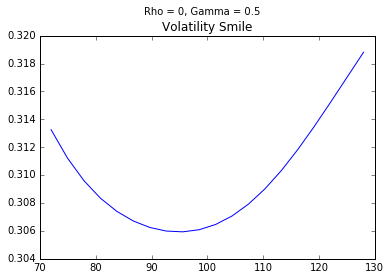

In [22]:
# Rho = 0
plot_leverage(8000, 5, mesh, S0, a0, gamma, 0, T, sigma_Dup)
plot_smile(1000, 10, mesh, S0, a0, gamma, 0, T)

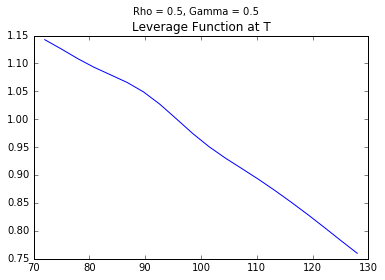

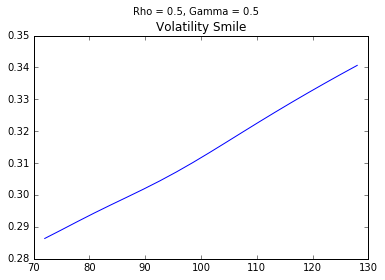

In [23]:
# Rho = 0.5
plot_leverage(8000, 5, mesh, S0, a0, gamma, 0.5, T, sigma_Dup)
plot_smile(1000, 10, mesh, S0, a0, gamma, 0.5, T)

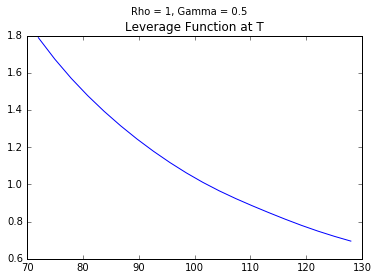

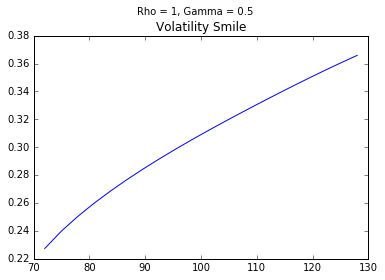

In [24]:
# Rho = 1
plot_leverage(8000, 5, mesh, S0, a0, gamma, 1, T, sigma_Dup)
plot_smile(1000, 10, mesh, S0, a0, gamma, 1, T)

From plots above, we can see that the volatility smiles of the pure stochastic volatility changes as $\rho$ changes, but the leverage function always compensate the volatility smile to make the local volatility calibrated to the market volatility.